# Measure transport with KSD - Toy Models

In [2]:
import torch

import numpy as np
import time

import pyro 
import pyro.distributions as dist
import pyro.distributions.transforms as T
from pyro.nn import AutoRegressiveNN

from MTKSD.loss import KSD_U, KSD_V, KSD_U_nograd , Wasserstein, ELBO
from MTKSD.get_score import get_score
from MTKSD.plot import plot_dist2D, plot_loss, plot_scatter
from MTKSD.toy_distributions import MOG2D, Banana2D, Sinusoidal2D
from MTKSD.polynomial_transport import theta_init, polynomial_transform
from MTKSD.neural_net_transport import ReLU_transport, transform_dist
from MTKSD.utils import save_output, train_KSD, train_ELBO, get_metric

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style

plt.rcParams['figure.figsize'] = [6,6]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

style.use("ggplot")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'


## Defining test problems

### Mixture of Gaussians

Mixture of Gaussians density of the form

$$ p(x,y) = \frac{1}{n}\sum_{i=1}^n\mathcal{N}(x,y;\mu_i,v^2 I_2), $$

where $\mathcal{N}(x,y;\mu,K)$ is the bivariate Gaussian density with mean vector $\mu$ and covariance matrix $K$. We fix our ```mog2D``` sample for sample quality measurement.

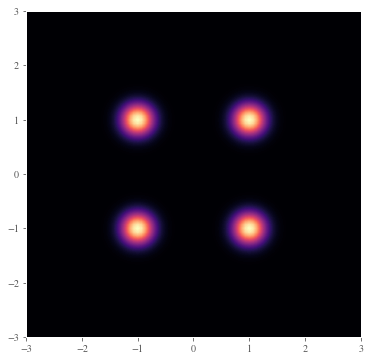

In [3]:
means = torch.Tensor([[1,1],[-1,1],[1,-1],[-1,-1]])
var = 0.2

mog2D = MOG2D(means, var)

torch.manual_seed(0)
mog2D_sample = mog2D.sample(10000)

plot_dist2D(mog2D,[-3,3],[-3,3],n_steps=100)

### Banana

Banana density of the form

$$ p(x,y) = \mathcal{N}(x;0,v_1^2) \mathcal{N}(y; ax_1^2, v_2^2), $$

where $\mathcal{N}(x;\mu,\sigma^2)$ is the univariate Gaussian density with mean $\mu$ and variance $\sigma^2$. We fix our ```banana2D``` sample for sample quality measurement.

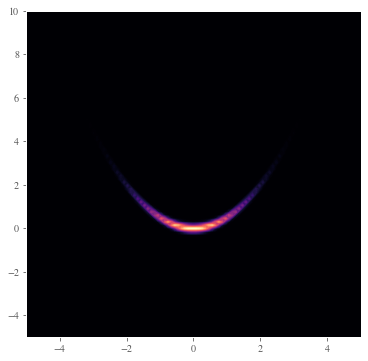

In [15]:
a,v1,v2 = 0.5,1,0.1
var = [a,v1,v2]

banana2D = Banana2D(var)

torch.manual_seed(0)
banana2D_sample = banana2D.sample(10000)

plot_dist2D(banana2D, [-5,5], [-5,10],n_steps=100)

### Sinusoidal

Sinusoidal density of the form

$$ p(x,y) = \mathcal{N}(x;0,v_1^2) \mathcal{N}(y; \sin(ax), v_2^2), $$

where $\mathcal{N}(x;\mu,\sigma^2)$ is the univariate Gaussian density with mean $\mu$ and variance $\sigma^2$. We fix our ```sinusoidal2D``` sample for sample quality measurement.

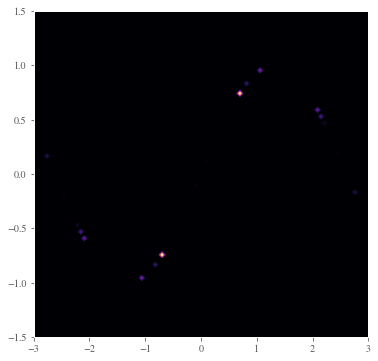

In [21]:
a,v1,v2 = 1.2,1.3,0.001
var = [a,v1,v2]

sinusoidal2D = Sinusoidal2D(var)

torch.manual_seed(0)
sinusoidal2D_samp = sinusoidal2D.sample(10000)

plot_dist2D(sinusoidal2D, [-3,3],[-1.5,1.5],n_steps=100)

# Measure transport experiments

## Inverse autoregressive flow (IAF)

### Mixture of Gaussians

In [7]:
torch.manual_seed(0)

base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
iaf_mog = T.AffineAutoregressive(AutoRegressiveNN(2, [40]))
transform_iaf_mog = dist.TransformedDistribution(base_dist, [iaf_mog])

In [8]:
train_KSD(transform_iaf_mog, mog2D, iaf_mog, "iaf_mog", save_out = True, n_steps = 10000)

saved output  KSD_iaf_mog  to  D:\Users\Python\MeasureTransportWithKSD\output


TransformedDistribution()

In [9]:
wass_maf_mog, KSD_maf_mog = get_metric(transform_iaf_mog, mog2D, mog2D_sample)
print(wass_maf_mog, KSD_maf_mog)

0.6676780618617253 tensor(6.7855, grad_fn=<MulBackward0>)


(-3.0, 3.0)

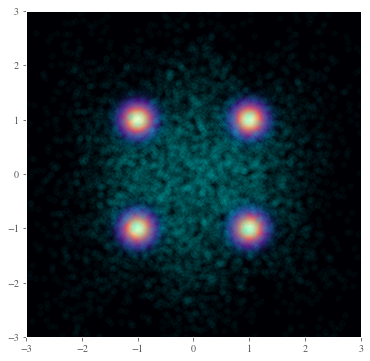

In [9]:
plot_dist2D(mog2D,[-3,3],[-3,3])
plot_scatter(transform_iaf_mog.sample((10000,)),color="cyan",alpha=0.03)
plt.xlim([-3,3])
plt.ylim([-3,3])

### Banana

In [5]:
torch.manual_seed(0)

base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
iaf_banana = T.AffineAutoregressive(AutoRegressiveNN(2, [40]))
transform_iaf_banana = dist.TransformedDistribution(base_dist, [iaf_banana])

In [6]:
train_KSD(transform_iaf_banana, banana2D, iaf_banana, "iaf_banana", save_out = True, n_steps = 10000)

saved output  KSD_iaf_banana  to  D:\Users\Python\MeasureTransportWithKSD\output


TransformedDistribution()

In [7]:
wass_iaf_banana, KSD_iaf_banana = get_metric(transform_iaf_banana, banana2D, banana2D_sample)
print(wass_iaf_banana, KSD_iaf_banana)

0.20267473021139532 tensor(0.1438, grad_fn=<MulBackward0>)


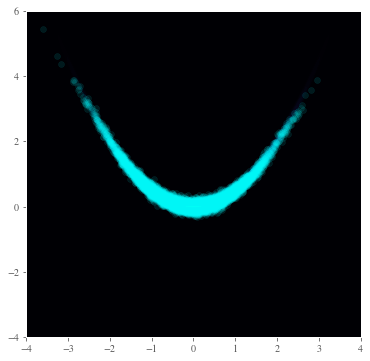

In [13]:
plot_dist2D(banana2D, [-4,4], [-4,6])
plot_scatter(transform_iaf_banana.sample((10000,)).detach(),color="cyan")

### Sinusoidal

In [6]:
torch.manual_seed(0)

base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
iaf_sin = T.AffineAutoregressive(AutoRegressiveNN(2, [40]))
transform_iaf_sin = dist.TransformedDistribution(base_dist, [iaf_sin])

In [7]:
train_KSD(transform_iaf_sin, sinusoidal2D, iaf_sin, "iaf_sin", save_out = True, n_steps = 10000)

saved output  KSD_iaf_sin  to  D:\Users\Python\MeasureTransportWithKSD\output


TransformedDistribution()

In [9]:
wass_iaf_sinusoidal, KSD_iaf_sinusoidal = get_metric(transform_iaf_sin, sinusoidal2D, sinusoidal2D_samp)
print(wass_iaf_sinusoidal, KSD_iaf_sinusoidal)

0.38141890977034915 tensor(7184088., grad_fn=<MulBackward0>)


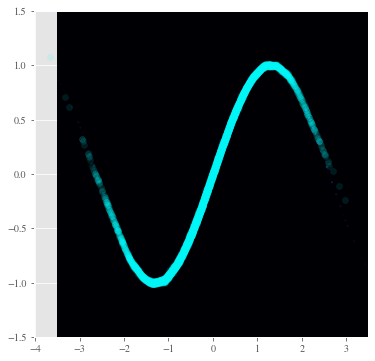

In [8]:
plot_dist2D(sinusoidal2D, [-3.5,3.5],[-1.5,1.5])
plot_scatter(transform_iaf_sin.sample((10000,)), color="cyan")

## IAF (stable)

### Mixture of Gaussians

In [6]:
torch.manual_seed(0)

base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
iafstable_mog = T.AffineAutoregressive(AutoRegressiveNN(2, [40]), stable=True)
transform_iafstable_mog = dist.TransformedDistribution(base_dist, [iafstable_mog])

In [7]:
train_KSD(transform_iafstable_mog, mog2D, iafstable_mog, "iafstable_mog", save_out = True, n_steps = 10000)

saved output  KSD_iafstable_mog  to  D:\Users\Python\MeasureTransportWithKSD\output


TransformedDistribution()

In [9]:
wass_iafstable_mog, KSD_iafstable_mog = get_metric(transform_iafstable_mog, mog2D, mog2D_sample)
print(wass_iafstable_mog, KSD_iafstable_mog)

0.6071275708300796 tensor(4.5473, grad_fn=<MulBackward0>)


(-3.0, 3.0)

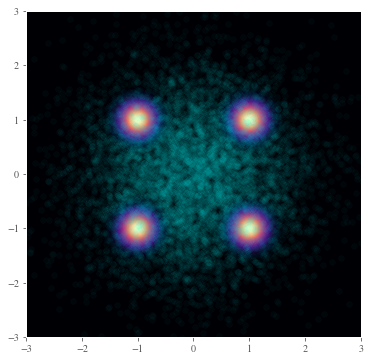

In [8]:
plot_dist2D(mog2D,[-3,3],[-3,3])
plot_scatter(transform_iafstable_mog.sample((10000,)),color="cyan",alpha=0.03)
plt.xlim([-3,3])
plt.ylim([-3,3])

### Banana

In [7]:
torch.manual_seed(0)

base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
iafstable_banana = T.AffineAutoregressive(AutoRegressiveNN(2, [40]), stable=True)
transform_iafstable_banana = dist.TransformedDistribution(base_dist, [iafstable_banana])

In [8]:
train_KSD(transform_iafstable_banana, banana2D, iafstable_banana, "iafstable_banana", save_out = True, n_steps = 10000)

saved output  KSD_iafstable_banana  to  D:\Users\Python\MeasureTransportWithKSD\output


TransformedDistribution()

In [10]:
wass_iafstable_banana, KSD_iafstable_banana = get_metric(transform_iafstable_banana, banana2D, banana2D_sample)
print(wass_iafstable_banana, KSD_iafstable_banana)

0.16382656566178974 tensor(0.1575, grad_fn=<MulBackward0>)


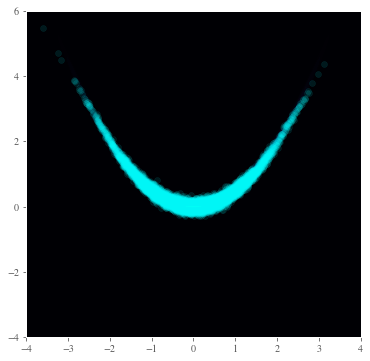

In [9]:
plot_dist2D(banana2D, [-4,4], [-4,6])
plot_scatter(transform_iafstable_banana.sample((10000,)).detach(),color="cyan")

### Sinusoidal

In [6]:
torch.manual_seed(0)

base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
iafstable_sin = T.AffineAutoregressive(AutoRegressiveNN(2, [40]),stable=True)
transform_iafstable_sin = dist.TransformedDistribution(base_dist, [iafstable_sin])

In [7]:
train_KSD(transform_iafstable_sin, sinusoidal2D, iafstable_sin, "iafstable_sin", save_out = True, n_steps = 10000)

saved output  KSD_iafstable_sin  to  D:\Users\Python\MeasureTransportWithKSD\output


TransformedDistribution()

In [9]:
wass_iafstable_sin, KSD_iafstable_sin = get_metric(transform_iafstable_sin, sinusoidal2D, sinusoidal2D_samp)
print(wass_iafstable_sin, KSD_iafstable_sin)

0.3522897473900454 tensor(1209177.2500, grad_fn=<MulBackward0>)


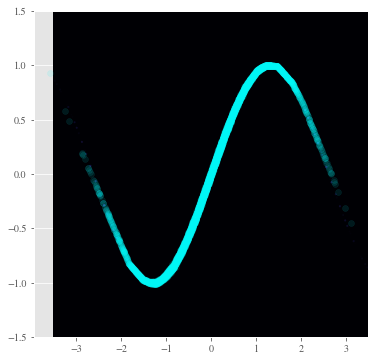

In [8]:
plot_dist2D(sinusoidal2D, [-3.5,3.5],[-1.5,1.5])
plot_scatter(transform_iafstable_sin.sample((10000,)), color="cyan")

## Neural autoregressive flow (NAF)

### Mixture of Gaussians

In [9]:
torch.manual_seed(1)

base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
arn = AutoRegressiveNN(2, [40], param_dims=[16]*3)
naf_mog = T.NeuralAutoregressive(arn, hidden_units=16)
transform_naf_mog = dist.TransformedDistribution(base_dist, [naf_mog])

In [ ]:
train_KSD(transform_naf_mog, mog2D, naf_mog, "naf_mog",n_steps=10000, save_out=False) 

In [71]:
wass_naf_mog, KSD_naf_mog = get_metric(transform_naf_mog, mog2D, mog2D_sample)
print(wass_naf_mog, KSD_naf_mog)

0.09485322170754427 tensor(0.0720, grad_fn=<MulBackward0>)


(-3.0, 3.0)

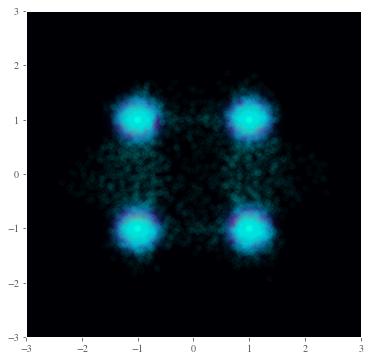

In [10]:
plot_dist2D(mog2D,[-3,3],[-3,3])
plot_scatter(transform_naf_mog.sample((10000,)),color="cyan",alpha=0.03)

plt.xlim(-3,3)
plt.ylim(-3,3)


### Banana

In [6]:
torch.manual_seed(0)

base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
arn = AutoRegressiveNN(2, [40], param_dims=[16]*3)
naf_banana = T.NeuralAutoregressive(arn, hidden_units=16)
transform_naf_banana = dist.TransformedDistribution(base_dist, [naf_banana])

In [7]:
train_KSD(transform_naf_banana, banana2D, naf_banana, "naf_banana",n_steps=10000, save_out=True)

saved output  KSD_naf_banana  to  D:\Users\Python\MeasureTransportWithKSD\output


TransformedDistribution()

In [9]:
wass_naf_banana, KSD_naf_banana = get_metric(transform_naf_banana, banana2D, banana2D_sample)
print(wass_naf_banana, KSD_naf_banana)

0.394624191528956 tensor(0.5637, grad_fn=<MulBackward0>)


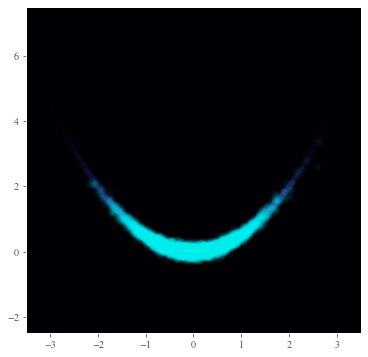

In [8]:
plot_dist2D(banana2D, [-5,5], [-5,10])

plt.xlim([-3.5,3.5])
plt.ylim([-2.5,7.5])

plot_scatter(transform_naf_banana.sample((10000,)), color="cyan", alpha=0.05)

### Sinusoidal

In [6]:
torch.manual_seed(6)

base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
arn = AutoRegressiveNN(2, [40], param_dims=[16]*3)
naf_sinusoidal = T.NeuralAutoregressive(arn, hidden_units=16)
transform_naf_sinusoidal = dist.TransformedDistribution(base_dist, [naf_sinusoidal])

In [7]:
train_KSD(transform_naf_sinusoidal, sinusoidal2D, naf_sinusoidal, "naf_sinusoidal",n_steps=10000, save_out=True)

saved output  KSD_naf_sinusoidal  to  D:\Users\Python\MeasureTransportWithKSD\output


TransformedDistribution()

In [9]:
wass_naf_sinusoidal, KSD_naf_sinusoidal = get_metric(transform_naf_sinusoidal, sinusoidal2D, sinusoidal2D_samp)
print(wass_naf_sinusoidal, KSD_naf_sinusoidal)

0.5453505847061769 tensor(776976.4375, grad_fn=<MulBackward0>)


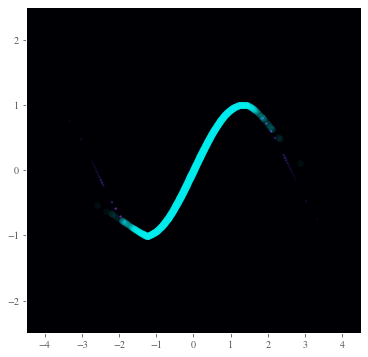

In [8]:
plot_dist2D(sinusoidal2D, [-5,5], [-3,3])

plt.xlim([-4.5,4.5])
plt.ylim([-2.5,2.5])

plot_scatter(transform_naf_sinusoidal.sample((10000,)), color="cyan", alpha=0.05)

# Spline autoregressive flow

## Mixture of Gaussians

In [6]:
torch.manual_seed(1)

input_dim = 2
count_bins = 8
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
hidden_dims = [input_dim * 10, input_dim * 10]
param_dims = [count_bins, count_bins, count_bins - 1, count_bins]
arn = AutoRegressiveNN(input_dim, hidden_dims, param_dims=param_dims)

saf_mog = T.SplineAutoregressive(input_dim, arn, count_bins=count_bins)
transform_saf_mog = dist.TransformedDistribution(base_dist, [saf_mog])

In [7]:
train_ELBO(transform_saf_mog, dist.MultivariateNormal(torch.zeros(2), torch.eye(2)), saf_mog, "",n_steps=1000, save_out=False) #pretrain to get good initialisiation

saved output  ELBO_  to  D:\Users\Python\MeasureTransportWithKSD\output


TransformedDistribution()

In [ ]:
train_KSD(transform_saf_mog, mog2D, saf_mog, "saf_mog",n_steps=10000, save_out=True)

In [14]:
wass_saf_mog, KSD_saf_mog = get_metric(transform_saf_mog, mog2D, mog2D_sample)
print(wass_saf_mog, KSD_saf_mog)

0.3025549919310498 tensor(0.1769, grad_fn=<MulBackward0>)


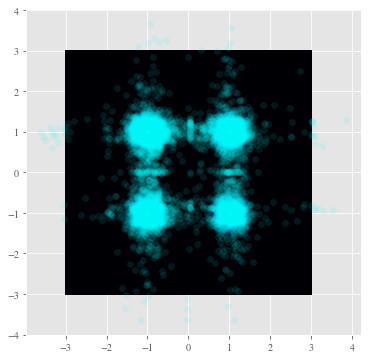

In [13]:
plot_dist2D(mog2D,[-3,3],[-3,3])
plot_scatter(transform_saf_mog.sample((10000,)),color="cyan")

## Banana

In [5]:
torch.manual_seed(0)

input_dim = 2
count_bins = 8
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
hidden_dims = [input_dim * 10, input_dim * 10]
param_dims = [count_bins, count_bins, count_bins - 1, count_bins]
arn = AutoRegressiveNN(input_dim, hidden_dims, param_dims=param_dims)

saf_banana = T.SplineAutoregressive(input_dim, arn, count_bins=count_bins)
transform_saf_banana = dist.TransformedDistribution(base_dist, [saf_banana])

In [6]:
train_ELBO(transform_saf_banana, dist.MultivariateNormal(torch.zeros(2), torch.eye(2)), saf_banana, "",n_steps=1000, save_out=False) #pretrain to get good initialisiation

TransformedDistribution()

In [7]:
train_KSD(transform_saf_banana, banana2D, saf_banana, "saf_banana",n_steps=10000, save_out=True)

saved output  KSD_saf_banana  to  D:\Users\Python\MeasureTransportWithKSD\output


TransformedDistribution()

In [9]:
wass_saf_banana, KSD_saf_banana = get_metric(transform_saf_banana, banana2D, banana2D_sample)
print(wass_saf_banana, KSD_saf_banana)

0.20082445125066772 tensor(8.4199, grad_fn=<MulBackward0>)


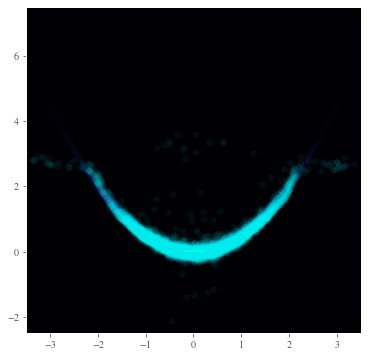

In [8]:
plot_dist2D(banana2D, [-5,5], [-5,10])

plt.xlim([-3.5,3.5])
plt.ylim([-2.5,7.5])

plot_scatter(transform_saf_banana.sample((10000,)), color="cyan", alpha=0.05)

## Sinusoidal

In [6]:
torch.manual_seed(0)

input_dim = 2
count_bins = 8
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
hidden_dims = [input_dim * 10, input_dim * 10]
param_dims = [count_bins, count_bins, count_bins - 1, count_bins]
arn = AutoRegressiveNN(input_dim, hidden_dims, param_dims=param_dims)

saf_sinusoidal = T.SplineAutoregressive(input_dim, arn, count_bins=count_bins)
transform_saf_sinusoidal = dist.TransformedDistribution(base_dist, [saf_sinusoidal])

In [8]:
train_ELBO(transform_saf_sinusoidal, dist.MultivariateNormal(torch.zeros(2), torch.eye(2)), saf_sinusoidal, "",n_steps=1000, save_out=False) #pretrain to get good initialisiation

TransformedDistribution()

In [9]:
train_KSD(transform_saf_sinusoidal, sinusoidal2D, saf_sinusoidal, "saf_sinusoidal",n_steps=10000, save_out=True)

saved output  KSD_saf_sinusoidal  to  D:\Users\Python\MeasureTransportWithKSD\output


TransformedDistribution()

In [9]:
wass_saf_sinusoidal, KSD_saf_sinusoidal = get_metric(transform_saf_sinusoidal, sinusoidal2D, sinusoidal2D_samp)
print(wass_saf_sinusoidal, KSD_saf_sinusoidal)

0.23230230840003702 tensor(1.1515e+08, grad_fn=<MulBackward0>)


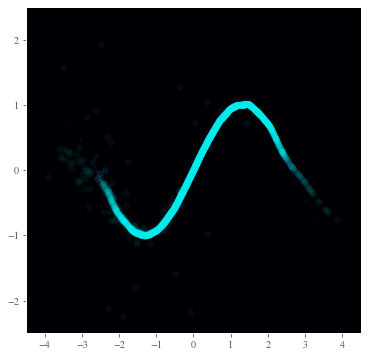

In [10]:
plot_dist2D(sinusoidal2D, [-5,5], [-3,3])

plt.xlim([-4.5,4.5])
plt.ylim([-2.5,2.5])

plot_scatter(transform_saf_sinusoidal.sample((10000,)), color="cyan", alpha=0.05)

# Block autoregressive flow

## Mixture of Gaussians

In [82]:
torch.manual_seed(2)

base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
baf_mog = T.BlockAutoregressive(input_dim=2)

transform_baf_mog = dist.TransformedDistribution(base_dist, [baf_mog])

In [9]:
train_KSD(transform_baf_mog, mog2D, baf_mog, "baf_mog",n_steps=10000, save_out=True)

saved output  KSD_baf_mog  to  D:\Users\Python\MeasureTransportWithKSD\output


TransformedDistribution()

In [12]:
wass_baf_mog, KSD_baf_mog = get_metric(transform_baf_mog, mog2D, mog2D_sample)
print(wass_baf_mog, KSD_baf_mog)

1.0166416668203642 tensor(0.0530, grad_fn=<MulBackward0>)


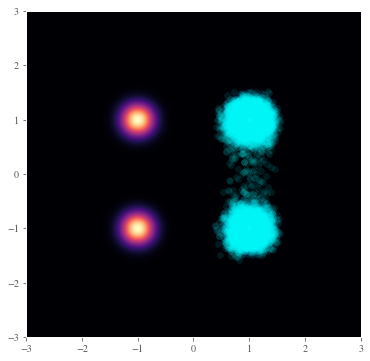

In [11]:
plot_dist2D(mog2D,[-3,3],[-3,3])
plot_scatter(transform_baf_mog.sample((10000,)),color="cyan")

## Banana

In [6]:
torch.manual_seed(2)

base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
baf_banana = T.BlockAutoregressive(input_dim=2, hidden_factors = [8,8])

transform_baf_banana = dist.TransformedDistribution(base_dist, [baf_banana])

In [7]:
train_KSD(transform_baf_banana, banana2D, baf_banana, "baf_banana",n_steps=10000,gamma=0.1, save_out=True)

saved output  KSD_baf_banana  to  D:\Users\Python\MeasureTransportWithKSD\output


TransformedDistribution()

In [9]:
wass_baf_banana, KSD_baf_banana = get_metric(transform_baf_banana, banana2D, banana2D_sample)
print(wass_baf_banana, KSD_baf_banana)

0.7022543034104137 tensor(0.3007, grad_fn=<MulBackward0>)


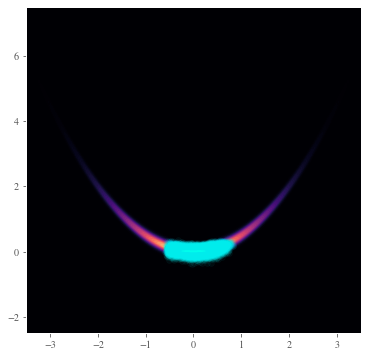

In [8]:
plot_dist2D(banana2D, [-5,5], [-5,10])

plt.xlim([-3.5,3.5])
plt.ylim([-2.5,7.5])

plot_scatter(transform_baf_banana.sample((10000,)), color="cyan", alpha=0.05)

## Sinusoidal

In [6]:
torch.manual_seed(1)

base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
baf_sinusoidal = T.BlockAutoregressive(input_dim=2)

transform_baf_sinusoidal = dist.TransformedDistribution(base_dist, [baf_sinusoidal])

In [7]:
train_KSD(transform_baf_sinusoidal, sinusoidal2D, baf_sinusoidal, "baf_sinusoidal",n_steps=10000, save_out=True)

saved output  KSD_baf_sinusoidal  to  D:\Users\Python\MeasureTransportWithKSD\output


TransformedDistribution()

In [9]:
wass_baf_sinusoidal, KSD_baf_sinusoidal = get_metric(transform_baf_sinusoidal, sinusoidal2D, sinusoidal2D_samp)
print(wass_baf_sinusoidal, KSD_baf_sinusoidal)

0.7790656693263179 tensor(651218., grad_fn=<MulBackward0>)


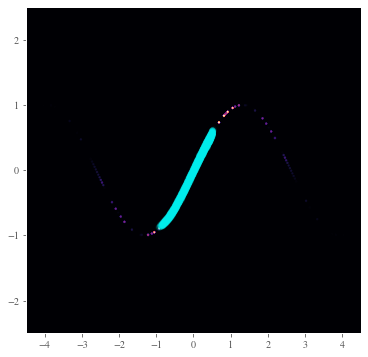

In [8]:
plot_dist2D(sinusoidal2D, [-5,5], [-3,3])

plt.xlim([-4.5,4.5])
plt.ylim([-2.5,2.5])

plot_scatter(transform_baf_sinusoidal.sample((10000,)), color="cyan", alpha=0.05)

## Polynomial transport (cubic)

### Mixture of Gaussians

In [26]:
order = 3
theta_mog = theta_init(3)

base_dist = dist.Normal(torch.zeros(2), torch.ones(2))

In [27]:
n_steps = 10000
gamma = 0.1
lr = 1e-3
save_out = True
print_loss = False
transform_name = "poly3_mog"
target = mog2D
m=200


loss_vec = torch.zeros(n_steps)

timings = np.zeros(n_steps // m)
start = time.time()
transform_samples = []
iter_num = []

optimizer = torch.optim.Adam([theta_mog], lr=lr)  # change

for i in range(n_steps):
    optimizer.zero_grad()

    base_dist_sample = base_dist.sample(torch.Size([100, ]))
    sample = polynomial_transform(base_dist_sample, theta_mog, order)  # change

    loss = KSD_U(sample, target.score, gamma)
    loss.backward()

    optimizer.step()

    loss_vec[i] = loss.clone().detach()

    if (i + 1) % m == 0 and save_out is True:
        timings[i // m] = time.time() - start
        transform_samples.append(polynomial_transform(base_dist.sample(torch.Size([10000, ])), theta_mog, order))
        iter_num.append(i)

    if (i + 1) % (n_steps // 2) == 0 and print_loss is True:
        print("iteration: " + str(i + 1) + ", loss: " + str(loss))
        plot_loss(loss_vec[:i], 200, log=False)
        plt.show()

if save_out is True:
    save_output([timings, transform_samples, iter_num], "KSD_" + transform_name, "output")


saved output  KSD_poly3_mog  to  D:\Users\Python\MeasureTransportWithKSD\output


In [29]:
torch.manual_seed(0)
final_samps = polynomial_transform(base_dist.sample(torch.Size([10000, ])), theta_mog, order).detach()
wass_poly3_mog = Wasserstein(mog2D_sample, final_samps)
final_samps.requires_grad_(True)
KSD_poly3_mog = KSD_U_nograd(final_samps, mog2D.score, gamma = 1)

print(wass_poly3_mog, KSD_poly3_mog)

0.5059017062494622 tensor(1.9972)


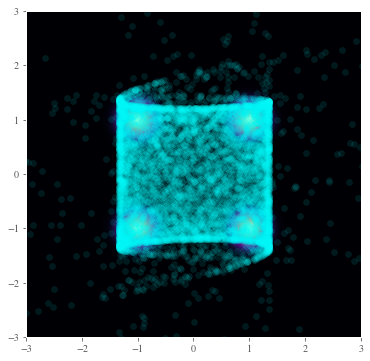

In [28]:
plot_dist2D(mog2D,[-3,3],[-3,3])
plt.xlim([-3,3])
plt.ylim([-3,3])
plot_scatter(polynomial_transform(base_dist.sample(torch.Size([10000, ])), theta_mog, order).detach(),color="cyan")

### Banana

In [30]:
order = 3
theta_banana = theta_init(3)

base_dist = dist.Normal(torch.zeros(2), torch.ones(2))

In [31]:
n_steps = 10000
gamma = 0.1
lr = 1e-3
save_out = True
print_loss = False
transform_name = "poly3_banana"
target = banana2D
m=200


loss_vec = torch.zeros(n_steps)

timings = np.zeros(n_steps // m)
start = time.time()
transform_samples = []
iter_num = []

optimizer = torch.optim.Adam([theta_banana], lr=lr)  # change

for i in range(n_steps):
    optimizer.zero_grad()

    base_dist_sample = base_dist.sample(torch.Size([100, ]))
    sample = polynomial_transform(base_dist_sample, theta_banana, order)  # change

    loss = KSD_U(sample, target.score, gamma)
    loss.backward()

    optimizer.step()

    loss_vec[i] = loss.clone().detach()

    if (i + 1) % m == 0 and save_out is True:
        timings[i // m] = time.time() - start
        transform_samples.append(polynomial_transform(base_dist.sample(torch.Size([10000, ])), theta_banana, order))
        iter_num.append(i)

    if (i + 1) % (n_steps // 2) == 0 and print_loss is True:
        print("iteration: " + str(i + 1) + ", loss: " + str(loss))
        plot_loss(loss_vec[:i], 200, log=False)
        plt.show()

if save_out is True:
    save_output([timings, transform_samples, iter_num], "KSD_" + transform_name, "output")


saved output  KSD_poly3_banana  to  D:\Users\Python\MeasureTransportWithKSD\output


In [33]:
torch.manual_seed(0)
final_samps = polynomial_transform(base_dist.sample(torch.Size([10000, ])), theta_banana, order).detach()
wass_poly3_banana = Wasserstein(banana2D_sample, final_samps)
final_samps.requires_grad_(True)
KSD_poly3_banana = KSD_U_nograd(final_samps, banana2D.score, gamma = 1)

print(wass_poly3_banana, KSD_poly3_banana)

0.2542342942823744 tensor(0.1700)


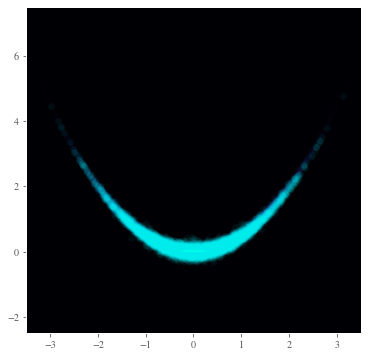

In [32]:
plot_dist2D(banana2D, [-5,5], [-5,10])

plt.xlim([-3.5,3.5])
plt.ylim([-2.5,7.5])

plot_scatter(polynomial_transform(base_dist.sample(torch.Size([10000, ])), theta_banana, order).detach(), color="cyan", alpha=0.05)

### Sinusoidal

In [34]:
order = 3
theta_sinusoidal = theta_init(order)

base_dist = dist.Normal(torch.zeros(2), torch.ones(2))

In [35]:
n_steps = 10000
gamma = 0.1
lr = 1e-3
save_out = True
print_loss = False
transform_name = "poly3_sinusoidal"
target = sinusoidal2D
m=200


loss_vec = torch.zeros(n_steps)

timings = np.zeros(n_steps // m)
start = time.time()
transform_samples = []
iter_num = []

optimizer = torch.optim.Adam([theta_sinusoidal], lr=lr)  # change

for i in range(n_steps):
    optimizer.zero_grad()

    base_dist_sample = base_dist.sample(torch.Size([100, ]))
    sample = polynomial_transform(base_dist_sample, theta_sinusoidal, order)  # change

    loss = KSD_U(sample, target.score, gamma)
    loss.backward()

    optimizer.step()

    loss_vec[i] = loss.clone().detach()

    if (i + 1) % m == 0 and save_out is True:
        timings[i // m] = time.time() - start
        transform_samples.append(polynomial_transform(base_dist.sample(torch.Size([10000, ])), theta_sinusoidal, order))
        iter_num.append(i)

    if (i + 1) % (n_steps // 2) == 0 and print_loss is True:
        print("iteration: " + str(i + 1) + ", loss: " + str(loss))
        plot_loss(loss_vec[:i], 200, log=False)
        plt.show()

if save_out is True:
    save_output([timings, transform_samples, iter_num], "KSD_" + transform_name, "output")


saved output  KSD_poly3_sinusoidal  to  D:\Users\Python\MeasureTransportWithKSD\output


In [38]:
torch.manual_seed(0)
final_samps = polynomial_transform(base_dist.sample(torch.Size([10000, ])), theta_sinusoidal, order).detach()
wass_poly3_sinusoidal = Wasserstein(sinusoidal2D_samp, final_samps)
final_samps.requires_grad_(True)
KSD_poly3_sinusoidal = KSD_U_nograd(final_samps, sinusoidal2D.score, gamma = 1)

print(wass_poly3_sinusoidal, KSD_poly3_sinusoidal)

0.4032546657184745 tensor(5452139.5000)


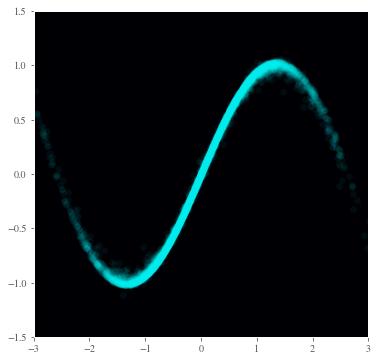

In [36]:
plot_dist2D(sinusoidal2D, [-5,5], [-5,10])

plt.xlim([-3,3])
plt.ylim([-1.5,1.5])

plot_scatter(polynomial_transform(base_dist.sample(torch.Size([10000, ])), theta_sinusoidal, order).detach(), color="cyan", alpha=0.05)

# Mixture of flows

## Mixture of IAFs

### Mixture of Gaussians

In [79]:
torch.manual_seed(4)

base_dist1 = dist.Normal(torch.Tensor([-2,-2]), torch.ones(2))
iaf_mog1 = T.AffineAutoregressive(AutoRegressiveNN(2, [8]))
transform_iaf_mog1 = dist.TransformedDistribution(base_dist1, [iaf_mog1])

base_dist2 = dist.Normal(torch.Tensor([2,2]), torch.ones(2))
iaf_mog2 = T.AffineAutoregressive(AutoRegressiveNN(2, [8]))
transform_iaf_mog2 = dist.TransformedDistribution(base_dist2, [iaf_mog2])

base_dist3 = dist.Normal(torch.Tensor([-2,2]), torch.ones(2))
iaf_mog3 = T.AffineAutoregressive(AutoRegressiveNN(2, [8]))
transform_iaf_mog3 = dist.TransformedDistribution(base_dist3, [iaf_mog3])

base_dist4 = dist.Normal(torch.Tensor([2,-2]), torch.ones(2))
iaf_mog4 = T.AffineAutoregressive(AutoRegressiveNN(2, [8]))
transform_iaf_mog4 = dist.TransformedDistribution(base_dist4, [iaf_mog4])

In [80]:
steps = 30000
m = 200
save_out = True
print_loss = False
transform_name = "mixtureiaf_mog"

loss_vec = torch.zeros(steps)
timings = np.zeros(steps // m)
start = time.time()
transform_samples = []
iter_num = []

params = list(iaf_mog1.parameters()) + list(iaf_mog2.parameters()) + list(iaf_mog3.parameters()) + list(iaf_mog4.parameters())

optimizer = torch.optim.Adam(params)

for i in range(steps):
    optimizer.zero_grad() 

    n_mix = 100 // 4
    base_dist_samps1 = base_dist1.sample(torch.Size([n_mix,]))
    base_dist_samps2 = base_dist2.sample(torch.Size([n_mix,]))
    base_dist_samps3 = base_dist3.sample(torch.Size([n_mix,]))
    base_dist_samps4 = base_dist4.sample(torch.Size([n_mix,]))
    
    samps1 = transform_iaf_mog1.transforms[0](base_dist_samps1) #change
    samps2 = transform_iaf_mog2.transforms[0](base_dist_samps2)
    samps3 = transform_iaf_mog3.transforms[0](base_dist_samps3)
    samps4 = transform_iaf_mog4.transforms[0](base_dist_samps4)
    
    samps = torch.cat([samps1,samps2,samps3,samps4])
    
    loss = KSD_U(samps, mog2D.score, 0.1) 
    loss.backward()

    if (i + 1) % m == 0 and save_out is True:
        timings[i // m] = time.time() - start
        s1 = transform_iaf_mog1.sample((2500,)) #change
        s2 = transform_iaf_mog2.sample((2500,))
        s3 = transform_iaf_mog3.sample((2500,))
        s4 = transform_iaf_mog4.sample((2500,))
        s = torch.cat([s1,s2,s3,s4])
        transform_samples.append(s)
        iter_num.append(i)
    
    optimizer.step()
    
    loss_vec[i] = loss.clone().detach() 
    
    transform_iaf_mog1.clear_cache()
    transform_iaf_mog2.clear_cache()
    transform_iaf_mog3.clear_cache()
    transform_iaf_mog4.clear_cache()
    
    if (i+1) % 1000 == 0 and print_loss is True:
        print("iteration: " + str(i+1) + ", loss: " + str(loss))
        plot_loss(loss_vec[:i],200) 
        plt.show()
        
if save_out is True:
    save_output([timings, transform_samples, iter_num], "KSD_" + transform_name, "output")

saved output  KSD_mixtureiaf_mog  to  D:\Users\Python\MeasureTransportWithKSD\output


(-3.0, 3.0)

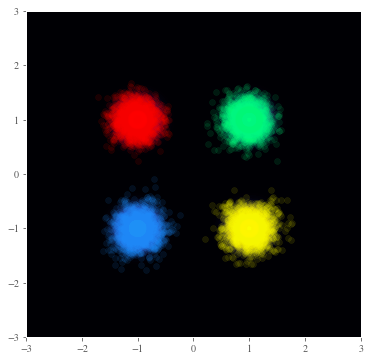

In [81]:
torch.manual_seed(0)
a1 = transform_iaf_mog1.sample((2500,))
a2 = transform_iaf_mog2.sample((2500,))
a3 = transform_iaf_mog3.sample((2500,))
a4 = transform_iaf_mog4.sample((2500,))
allsamps = torch.cat([a1,a2,a3,a4])

plot_dist2D(mog2D,[-3,3],[-3,3])
plot_scatter(a1.detach(),color="dodgerblue")
plot_scatter(a2.detach(),color="springgreen")
plot_scatter(a3.detach(),color="red")
plot_scatter(a4.detach(),color="yellow")
plt.xlim([-3,3])
plt.ylim([-3,3])

In [9]:
final_samps = allsamps
wass = Wasserstein(mog2D_sample, final_samps)

final_samps.requires_grad_(True)
ksd_u = KSD_U(final_samps, mog2D.score, gamma=1)

wass_mixtureiaf_mog, ksd_mixtureiaf_mog = wass,ksd_u
print(wass_mixtureiaf_mog,ksd_mixtureiaf_mog)

0.03746423499644384 tensor(0.1465, grad_fn=<MulBackward0>)


### Banana

In [ ]:
torch.manual_seed(4)

base_dist1 = dist.Normal(torch.Tensor([-2,-2]), torch.ones(2))
iaf_banana1 = T.AffineAutoregressive(AutoRegressiveNN(2, [8]))
transform_iaf_banana1 = dist.TransformedDistribution(base_dist1, [iaf_banana1])

base_dist2 = dist.Normal(torch.Tensor([2,2]), torch.ones(2))
iaf_banana2 = T.AffineAutoregressive(AutoRegressiveNN(2, [8]))
transform_iaf_banana2 = dist.TransformedDistribution(base_dist2, [iaf_banana2])

base_dist3 = dist.Normal(torch.Tensor([-2,2]), torch.ones(2))
iaf_banana3 = T.AffineAutoregressive(AutoRegressiveNN(2, [8]))
transform_iaf_banana3 = dist.TransformedDistribution(base_dist3, [iaf_banana3])

base_dist4 = dist.Normal(torch.Tensor([2,-2]), torch.ones(2))
iaf_banana4 = T.AffineAutoregressive(AutoRegressiveNN(2, [8]))
transform_iaf_banana4 = dist.TransformedDistribution(base_dist4, [iaf_banana4])

In [ ]:
steps = 30000
m = 200
save_out = True
print_loss = False
transform_name = "mixtureiaf_banana"

loss_vec = torch.zeros(steps)
timings = np.zeros(steps // m)
start = time.time()
transform_samples = []
iter_num = []

params = list(iaf_banana1.parameters()) + list(iaf_banana2.parameters()) + list(iaf_banana3.parameters()) + list(iaf_banana4.parameters())

optimizer = torch.optim.Adam(params)

for i in range(steps):
    optimizer.zero_grad() 

    n_mix = 100 // 4
    base_dist_samps1 = base_dist1.sample(torch.Size([n_mix,]))
    base_dist_samps2 = base_dist2.sample(torch.Size([n_mix,]))
    base_dist_samps3 = base_dist3.sample(torch.Size([n_mix,]))
    base_dist_samps4 = base_dist4.sample(torch.Size([n_mix,]))
    
    samps1 = transform_iaf_banana1.transforms[0](base_dist_samps1) #change
    samps2 = transform_iaf_banana2.transforms[0](base_dist_samps2)
    samps3 = transform_iaf_banana3.transforms[0](base_dist_samps3)
    samps4 = transform_iaf_banana4.transforms[0](base_dist_samps4)
    
    samps = torch.cat([samps1,samps2,samps3,samps4])
    
    mixture = uniform_mixture([transform_iaf_banana1,transform_iaf_banana2,transform_iaf_banana3,transform_iaf_banana4])
    
    loss = KSD_U(samps, banana2D.score, 0.1) 
    loss.backward()


    if (i + 1) % m == 0 and save_out is True:
        timings[i // m] = time.time() - start
        s1 = transform_iaf_banana1.sample((2500,)) #change
        s2 = transform_iaf_banana2.sample((2500,))
        s3 = transform_iaf_banana3.sample((2500,))
        s4 = transform_iaf_banana4.sample((2500,))
        s = torch.cat([s1,s2,s3,s4])
        transform_samples.append(s)
        iter_num.append(i)
    
    optimizer.step()
    
    loss_vec[i] = loss.clone().detach() 
    
    transform_iaf_banana1.clear_cache()
    transform_iaf_banana2.clear_cache()
    transform_iaf_banana3.clear_cache()
    transform_iaf_banana4.clear_cache()
    
    if (i+1) % 1000 == 0 and print_loss is True:
        print("iteration: " + str(i+1) + ", loss: " + str(loss))
        plot_loss(loss_vec[:i],200) 
        plt.show()
        
if save_out is True:
    save_output([timings, transform_samples, iter_num], "KSD_" + transform_name, "output")

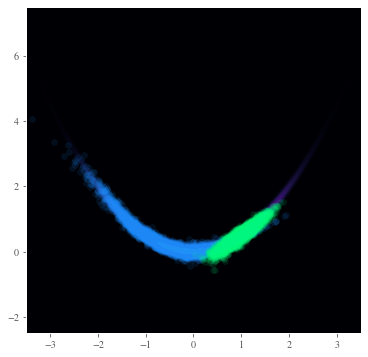

In [9]:
plot_dist2D(banana2D, [-5,5], [-5,10])

plt.xlim([-3.5,3.5])
plt.ylim([-2.5,7.5])

torch.manual_seed(0)
a1 = transform_iaf_banana1.sample((2500,))
a2 = transform_iaf_banana2.sample((2500,))
a3 = transform_iaf_banana1.sample((2500,))
a4 = transform_iaf_banana1.sample((2500,))

allsamps = torch.cat([a1,a2,a3,a4])


plot_scatter(a1.detach(),color="dodgerblue")
plot_scatter(a2.detach(),color="springgreen")
plot_scatter(a3.detach(),color="red")
plot_scatter(a4.detach(),color="yellow")

In [37]:
final_samps = allsamps
wass = Wasserstein(banana2D_sample, final_samps)

final_samps.requires_grad_(True)
ksd_u = KSD_U(final_samps, banana2D.score, gamma=1)

wass_mixtureiaf_banana, ksd_mixtureiaf_banana = wass,ksd_u
print(wass_mixtureiaf_banana,ksd_mixtureiaf_banana)

0.19328891644045842 tensor(0.4463, grad_fn=<MulBackward0>)


### Sinusoidal

In [64]:
torch.manual_seed(17)

base_dist1 = dist.Normal(torch.Tensor([-2,-2]), torch.ones(2))
iaf_sinusoidal1 = T.AffineAutoregressive(AutoRegressiveNN(2, [8]))
transform_iaf_sinusoidal1 = dist.TransformedDistribution(base_dist1, [iaf_sinusoidal1])

base_dist2 = dist.Normal(torch.Tensor([2,2]), torch.ones(2))
iaf_sinusoidal2 = T.AffineAutoregressive(AutoRegressiveNN(2, [8]))
transform_iaf_sinusoidal2 = dist.TransformedDistribution(base_dist2, [iaf_sinusoidal2])

base_dist3 = dist.Normal(torch.Tensor([-2,2]), torch.ones(2))
iaf_sinusoidal3 = T.AffineAutoregressive(AutoRegressiveNN(2, [8]))
transform_iaf_sinusoidal3 = dist.TransformedDistribution(base_dist3, [iaf_sinusoidal3])

base_dist4 = dist.Normal(torch.Tensor([2,-2]), torch.ones(2))
iaf_sinusoidal4 = T.AffineAutoregressive(AutoRegressiveNN(2, [8]))
transform_iaf_sinusoidal4 = dist.TransformedDistribution(base_dist4, [iaf_sinusoidal4])

In [65]:
steps = 30000
m = 200
save_out = True
print_loss = False
transform_name = "mixtureiaf_sinusoidal"

loss_vec = torch.zeros(steps)
timings = np.zeros(steps // m)
start = time.time()
transform_samples = []
iter_num = []

params = list(iaf_sinusoidal1.parameters()) + list(iaf_sinusoidal2.parameters()) + list(iaf_sinusoidal3.parameters()) + list(iaf_sinusoidal4.parameters())

optimizer = torch.optim.Adam(params)

for i in range(steps):
    optimizer.zero_grad() 

    n_mix = 100 // 4
    base_dist_samps1 = base_dist1.sample(torch.Size([n_mix,]))
    base_dist_samps2 = base_dist2.sample(torch.Size([n_mix,]))
    base_dist_samps3 = base_dist3.sample(torch.Size([n_mix,]))
    base_dist_samps4 = base_dist4.sample(torch.Size([n_mix,]))
    
    samps1 = transform_iaf_sinusoidal1.transforms[0](base_dist_samps1) #change
    samps2 = transform_iaf_sinusoidal2.transforms[0](base_dist_samps2)
    samps3 = transform_iaf_sinusoidal3.transforms[0](base_dist_samps3)
    samps4 = transform_iaf_sinusoidal4.transforms[0](base_dist_samps4)
    
    samps = torch.cat([samps1,samps2,samps3,samps4])
    
    loss = KSD_U(samps, sinusoidal2D.score, 0.1)  #ELBO(mixxx, mog2D, samps)  
    loss.backward()

    if (i + 1) % m == 0 and save_out is True:
        timings[i // m] = time.time() - start
        s1 = transform_iaf_sinusoidal1.sample((2500,)) #change
        s2 = transform_iaf_sinusoidal2.sample((2500,))
        s3 = transform_iaf_sinusoidal3.sample((2500,))
        s4 = transform_iaf_sinusoidal4.sample((2500,))
        s = torch.cat([s1,s2,s3,s4])
        transform_samples.append(s)
        iter_num.append(i)
    
    optimizer.step()
    
    loss_vec[i] = loss.clone().detach() 
    
    transform_iaf_sinusoidal1.clear_cache()
    transform_iaf_sinusoidal2.clear_cache()
    transform_iaf_sinusoidal3.clear_cache()
    transform_iaf_sinusoidal4.clear_cache()
    
    if (i+1) % 1000 == 0 and print_loss is True:
        print("iteration: " + str(i+1) + ", loss: " + str(loss))
        plot_loss(loss_vec[:i],200) 
        plt.show()
        
if save_out is True:
    save_output([timings, transform_samples, iter_num], "KSD_" + transform_name, "output")

saved output  KSD_mixtureiaf_sinusoidal  to  D:\Users\Python\MeasureTransportWithKSD\output


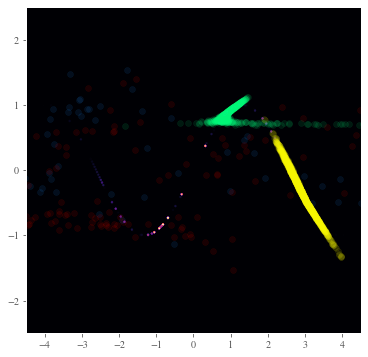

In [66]:
plot_dist2D(sinusoidal2D, [-5,5], [-3,3])

plt.xlim([-4.5,4.5])
plt.ylim([-2.5,2.5])

torch.manual_seed(0)
a1 = transform_iaf_sinusoidal1.sample((2500,))
a2 = transform_iaf_sinusoidal2.sample((2500,))
a3 = transform_iaf_sinusoidal3.sample((2500,))
a4 = transform_iaf_sinusoidal4.sample((2500,))
allsamps = torch.cat([a1,a2,a3,a4])

plot_scatter(a1.detach(),color="dodgerblue")
plot_scatter(a2.detach(),color="springgreen")
plot_scatter(a3.detach(),color="red")
plot_scatter(a4.detach(),color="yellow")

In [63]:
final_samps = allsamps
wass = Wasserstein(sinusoidal2D_samp, final_samps)

final_samps.requires_grad_(True)
ksd_u = KSD_U_nograd(final_samps, sinusoidal2D.score, gamma=1)

wass_mixtureiaf_sinusoidal, ksd_mixtureiaf_sinusoidal = wass,ksd_u
print(wass_mixtureiaf_sinusoidal,ksd_mixtureiaf_sinusoidal)

1.286366939415086 tensor(26599974.)
